In [ ]:
import random
import numpy as np
import random
import gym
# from gym.wrappers import Monitor
import glob
import io
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML

In [ ]:
import gym
import random

# Setting up the environment
env = gym.make('Taxi-v3',render_mode="human")
env.reset()

# Number of states
num_states = env.observation_space.n
print("Number of states:", num_states)

# Number of actions
num_actions = env.action_space.n
print("Number of actions that an agent can take:", num_actions)

# Primitive Actions
actions = ["south", "north", "east", "west", "pick", "drop"]

# Example Transitions
random_action = random.randint(0, num_actions - 1)
print("Action taken:", actions[random_action])
next_state, reward, is_terminal, _ = env.step(random_action)
print("Next state:", next_state)
print("Reward received:", reward)
print("Terminal state:", is_terminal)

# Render the environment
env.render()


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Number of states: 500
Number of actions that an agent can take: 6
Action taken: south
Next state: 242
Reward received: -1
Terminal state: False


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [ ]:
def stateData(state):
  picdrop = state%20
  pos = state//20
  y = pos//5
  x = pos%5
  drop = picdrop%4
  passenger = picdrop//4
  return x,y,drop,passenger

In [ ]:
def egreedy_policy(q_values,state,epsilon):
  if q_values[state].any() and random.random() > epsilon:
    #print('greedy', np.argmax(q_values[state]),q_values.shape)
    return np.argmax(q_values[state])
  choice = random.randint(0,q_values.shape[-1]-1)
  #print('random',choice,q_values.shape)
  return choice

In [ ]:

from IPython.display import clear_output
import time

In [ ]:
nO=4 #number of options
goal = {0:[0,0],1:[0,4],2:[4,0],3:[4,3]}
def Option(env,state,Q,goalNum,eps=0.1,goal = goal):
  optdone = False
  x,y,pas,drop=env.decode(state)

  if (x==goal[goalNum][0] and y==goal[goalNum][1]):
      #print('Reached ',goalNum)
      optdone = True
      if pas == goalNum:
        optact = 4
      elif drop == goalNum:
        optact = 5
      else:
        optact = 1 if (goalNum in [0,1]) else 0
  else:
    optact = egreedy_policy(Q[goalNum], 5*x+y, epsilon=eps)
  return [optact,optdone]

In [ ]:
nO = 4 #number of options
goal = {0:[0,0],1:[0,4],2:[4,0],3:[4,3]}
def Option(env,state,Q,goalNum,eps=0.1,goal = goal):
  optdone = False
  x,y,pas,drop=env.decode(state)

  if (x==goal[goalNum][0] and y==goal[goalNum][1]):
      #print('Reached ',goalNum)
      optdone = True
      if pas == goalNum:
        optact = 4
      elif drop == goalNum:
        optact = 5
      else:
        optact = 1 if (goalNum in [0,1]) else 0
  else:
    optact = egreedy_policy(Q[goalNum], 5*x+y, epsilon=eps)
  return [optact,optdone]

In [ ]:
rewards2 = []
T = 1
goal = {0:[0,0],1:[0,4],2:[4,0],3:[4,3]}

# Add parameters you might need here
gamma = 0.9
alpha = 0.1

#Q-Table: (States x Actions) === (env.ns(48) x total actions(6))
nX = 5; nY = 5; nPas = 5; nDrop = 4
q_values_SMDP = np.zeros((nPas*nDrop,nO))
updates_SMDP = np.zeros((nPas*nDrop,nO))

Qopt = {i:np.zeros((num_states//20,num_actions-2)) for i in range(nO)} #Q-values for each option
eps = {i:0.01 for i in range(nO)}
eps_min = 0.01
eps_decay = 0.99
eps_main = 0.5
count = 0
Neps = 1000

# Iterate over Neps episodes
for i in range(Neps):
    print("Episode ",i)
    state = env.reset()
    done = False
    tot_rew = 0
    # While episode is not over
    while not done:

        # Choose action
        x,y,pas,drop = env.decode(state)
        subState = nDrop*pas+drop
        option = egreedy_policy(q_values_SMDP, subState, epsilon=eps_main)
        eps_main = max(eps_min,eps_decay*eps_main)
        reward_bar = 0
        optdone = False
        move = 0
        prev = state

        #Go to location and drop/pick
        x,y,pas,drop = env.decode(state)
        optdone = False
        while not optdone and not done:
          # optact = policyOpt[drop][x,y]
          # state, reward, done,_ = env.step(optact)
          # tot_rew += reward
          # x,y,pas,drop = env.decode(state)
          # if x == goal[drop][0] and y==goal[drop][1]:
          #   findDrop = True
          optact,optdone = Option(env,state,Qopt,option,eps[option])

          [x,y,_,_]=  list(env.decode(state))

          next_state, reward, done,_ = env.step(optact)
          [x1,y1,_,_]=  list(env.decode(next_state))
          reward_bar = gamma*reward_bar + reward
          move += 1
          tot_rew+=reward

          eps[option] = max(eps_min,eps_decay*eps[option])
          tot_rew+=reward
          reward_surr = reward
          if optdone:
            reward_surr = 20
          if optact<4:
            Qopt[option][5*x+y, optact] = Qopt[option][5*x+y, optact] + alpha*(reward_surr + gamma*np.max(Qopt[option][5*x1+y1, :]) - Qopt[option][5*x+y, optact])
          state = next_state



            #--
        _,_,pas,drop = env.decode(state)
        subState = nDrop*pas+drop

        _,_,pas,drop = env.decode(prev)
        subPrev = nDrop*pas+drop

        q_values_SMDP[subPrev, option] += alpha*(reward_bar + (gamma**move)*np.max(q_values_SMDP[subState, :]) - q_values_SMDP[subPrev, option])
        updates_SMDP[subPrev, option] += 1
    rewards2.append(tot_rew)
    x,y,pas,drop = env.decode(state)
    if pas==drop:
      count+=1
      clear_output(wait=True)
      print('Success ({}/{}) = {}%'.format(count,i+1,100*count/(i+1)))



Success (983/1000) = 98.3%


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


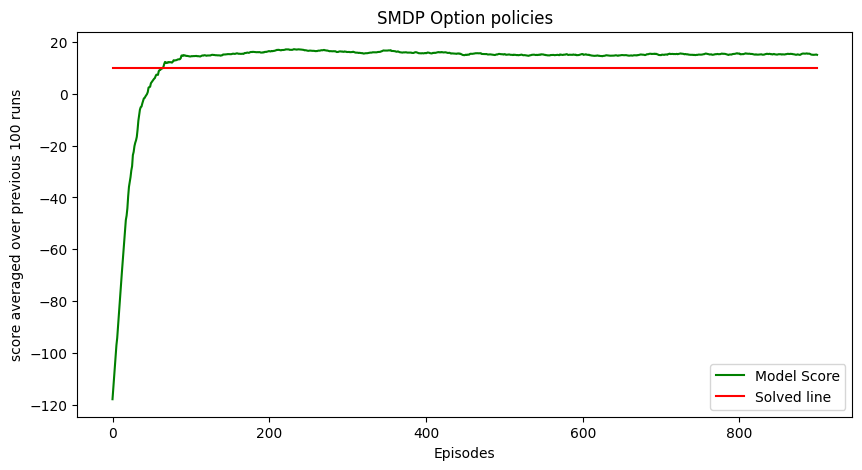

In [ ]:
plt.figure(figsize = (10,5))
avg_rews2 = [np.average(rewards2[i:i+100]) for i in range(len(rewards2)-100)]
plt.plot(avg_rews2,label = 'Model Score',color="green")
plt.plot([9.7 for i in range(len(avg_rews2))],label = 'Solved line',color="red")
plt.xlabel('Episodes')
plt.ylabel('score averaged over previous 100 runs')
plt.title('SMDP Option policies')
plt.legend()


Text(0.5, 1.0, 'Policy learnt by SMDP')

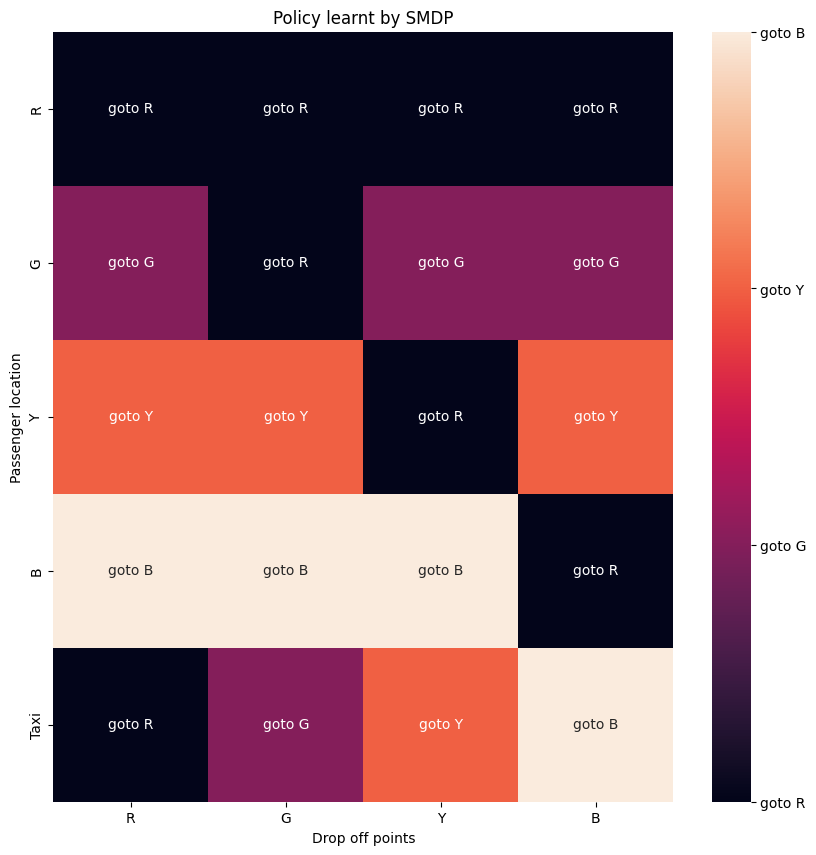

In [ ]:

Qmax_SMDP = np.argmax(q_values_SMDP,axis = 1).reshape(5,4)
labels = {0:'goto R',1:'goto G', 2:'goto Y', 3:'goto B'}
annot_text = np.vectorize(labels.get)(Qmax_SMDP)
figure, axis = plt.subplots(1, 1,figsize=(10,10))
ax = sns.heatmap(Qmax_SMDP,ax=axis,xticklabels = ["R","G","Y","B"],yticklabels = ['R','G','Y','B','Taxi'],annot = annot_text,fmt = '')
c_bar = ax.collections[0].colorbar
c_bar.set_ticks([0, 1, 2, 3])
c_bar.set_ticklabels(['goto R','goto G', 'goto Y', 'goto B'])

axis.set_xlabel('Drop off points')
axis.set_ylabel("Passenger location")
axis.set_title('Policy learnt by SMDP')

In [ ]:
q_values_SMDP

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 4.75940552, -1.2439    , -1.91644471, -1.64370545],
       [ 3.90057137, -2.86521561, -5.14822397, -3.01260258],
       [ 4.66384215, -4.13620245, -4.37747638, -6.01288373],
       [-6.02794572,  4.3759787 , -4.16224286, -3.93878805],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [-2.62427597,  3.64956137, -2.44502228, -2.37888316],
       [-3.62007026,  5.72370139, -3.63499148, -4.11489036],
       [-4.09559531, -2.11786375,  3.74019853, -2.10693886],
       [-2.86106957, -2.32131126,  3.88425503, -2.27522613],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [-4.18858125, -3.76682121,  3.4691736 , -5.45486125],
       [-4.24349056, -3.221759  , -2.65184949,  5.63456658],
       [-1.17650938, -2.32121935, -1.4038455 ,  4.49646783],
       [-0.99293035, -2.03868485, -1.89999918,  4.51752708],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [15.55508087,  0.

In [ ]:
rewards2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[-400,
 -400,
 -400,
 -400,
 -418,
 -272,
 -418,
 -418,
 -400,
 -400,
 -400,
 -400,
 -400,
 -418,
 -400,
 -318,
 -418,
 -152,
 -268,
 -436,
 -358,
 -176,
 -178,
 -238,
 -140,
 -418,
 -114,
 -208,
 -108,
 -84,
 -120,
 -268,
 -322,
 -208,
 -188,
 -76,
 -8,
 -98,
 -96,
 -90,
 -30,
 -38,
 -38,
 -28,
 -58,
 -158,
 -4,
 14,
 -118,
 -22,
 -30,
 -30,
 -34,
 -18,
 -58,
 -46,
 8,
 18,
 -120,
 -18,
 12,
 -24,
 -2,
 -2,
 -46,
 -92,
 -50,
 18,
 18,
 8,
 -8,
 26,
 14,
 24,
 20,
 18,
 -22,
 -36,
 20,
 20,
 12,
 14,
 12,
 2,
 14,
 20,
 -28,
 -82,
 20,
 26,
 -4,
 26,
 16,
 26,
 4,
 16,
 20,
 14,
 18,
 4,
 14,
 16,
 4,
 22,
 8,
 6,
 12,
 20,
 12,
 20,
 24,
 18,
 2,
 10,
 8,
 14,
 12,
 20,
 20,
 26,
 0,
 10,
 12,
 18,
 22,
 12,
 8,
 14,
 22,
 8,
 16,
 12,
 22,
 18,
 12,
 18,
 14,
 20,
 0,
 12,
 -14,
 20,
 10,
 16,
 20,
 14,
 16,
 26,
 18,
 22,
 14,
 10,
 8,
 8,
 20,
 10,
 4,
 14,
 20,
 24,
 22,
 12,
 10,
 14,
 10,
 16,
 28,
 4,
 -10,
 18,
 20,
 10,
 28,
 20,
 10,
 14,
 14,
 18,
 10,
 24,
 18,
 22,
 30,
 

In [ ]:
updates_SMDP

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[  0.,   0.,   0.,   0.],
       [ 81.,   1.,   4.,   3.],
       [103.,   5.,   4.,   7.],
       [ 66.,   9.,   9.,   4.],
       [  4.,  77.,   9.,   6.],
       [  0.,   0.,   0.,   0.],
       [  6.,  81.,   2.,   4.],
       [  5., 102.,  14.,   3.],
       [  3.,   4.,  67.,   4.],
       [  5.,   2.,  86.,   6.],
       [  0.,   0.,   0.,   0.],
       [  6.,  14.,  88.,   4.],
       [  3.,   4.,   3.,  87.],
       [  3.,   2.,   3.,  76.],
       [  1.,   3.,   1.,  80.],
       [  0.,   0.,   0.,   0.],
       [228.,   3.,   0.,   0.],
       [  1., 243.,   3.,   2.],
       [  1.,   2., 262.,   3.],
       [  4.,   2.,   6., 252.]])

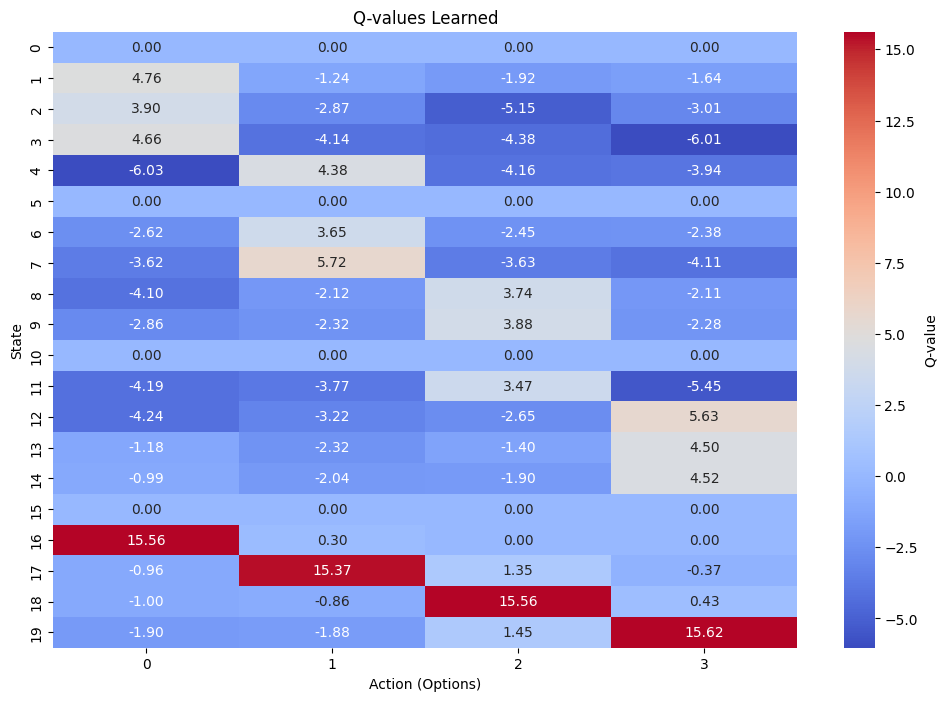

In [ ]:

def visualize_q_values(q_values):
    plt.figure(figsize=(12, 8))
    sns.heatmap(q_values, cmap='coolwarm', annot=True, fmt=".2f", cbar_kws={'label': 'Q-value'})
    plt.xlabel('Action (Options)')
    plt.ylabel('State')
    plt.title('Q-values Learned')
    plt.show()

visualize_q_values(q_values_SMDP)


Now we will consider any other options other than the one GotoR,GotoB,GotoY,GotoG

lets define some options using the primitive actiions

In [ ]:
policyOptionR = np.array([[1,3,0,0,0],
                 [1,3,0,0,0],
                 [1,3,3,3,3],
                 [1,1,1,1,1],
                 [1,1,1,1,1]
                 ])
policyOptionG = np.array([[0,0,2,2,1],
                 [0,0,2,2,1],
                 [2,2,2,1,1],
                 [1,2,1,1,1],
                 [1,2,1,1,1]
                 ])
policyOptionY = np.array([[0,3,0,0,0],
                          [0,3,0,0,0],
                          [0,3,2,3,3],
                          [0,1,1,1,3],
                          [0,1,3,1,3]
                          ])
policyOptionB = np.array([[0,0,0,0,3],
                          [0,0,0,0,3],
                          [2,1,2,0,3],
                          [1,1,1,0,3],
                          [1,1,1,0,3]
                          ])
policyOpt = [policyOptionR,policyOptionG,policyOptionY,policyOptionB]

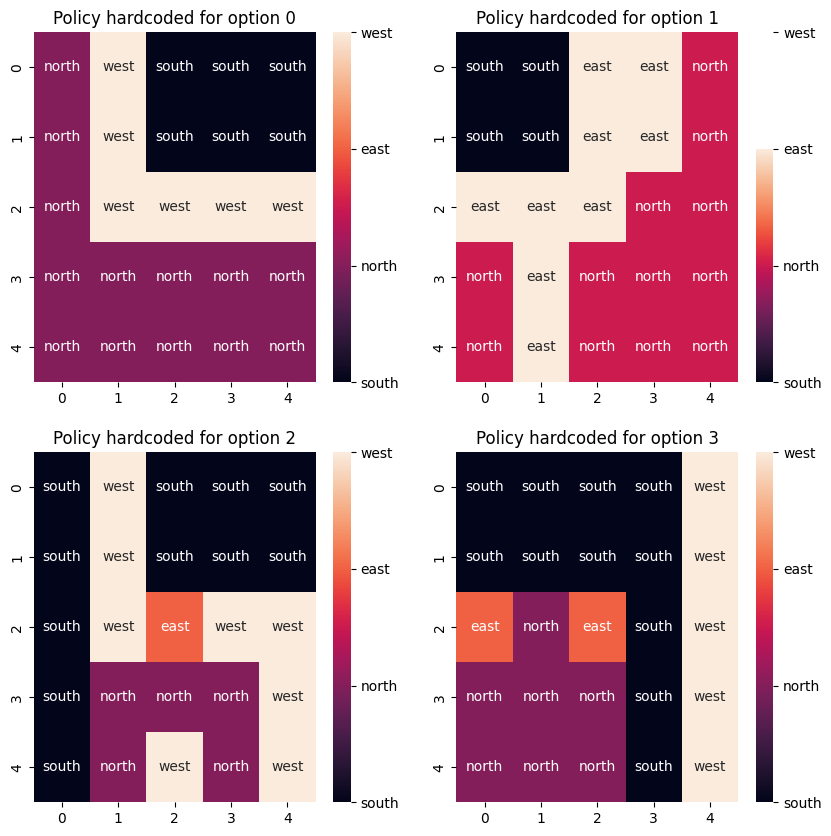

In [ ]:

figure, axis = plt.subplots(2,2,figsize=(10,10))
for i in range(2):
  for j in range(2):
    labels = {0:'south',1:'north', 2:'east', 3:'west'}
    annot_text = np.vectorize(labels.get)((policyOpt[2*i+j]))
    ax = sns.heatmap((policyOpt[2*i+j]),ax=axis[i,j],annot = annot_text,fmt='')
    axis[i,j].set_title("Policy hardcoded for option {}".format(i*2+j))
    c_bar = ax.collections[0].colorbar
    c_bar.set_ticks([i for i in range(4)])
    c_bar.set_ticklabels(['south','north','east','west'])

In [ ]:
rewards0 = []
T = 1
goal = {0:[0,0],1:[0,4],2:[4,0],3:[4,3]}
Neps = 1000
for i in range(Neps):
  print("Episode:",i)
  state = env.reset()
  done = False
  tot_rew = 0
  while not done:
    x,y,pas,drop = env.decode(state)

    #Go to passenger
    findPas = False
    while not findPas and not done:
      optact = policyOpt[pas][x,y]
      state, reward, done,_ = env.step(optact)
      tot_rew += reward
      x,y,pas,drop = env.decode(state)
      if x == goal[pas][0] and y==goal[pas][1]:
        findPas = True
      # clear_output(wait=True)
      # print(env.render())
      # time.sleep(T)

    #Pickup passenger
    optact = 4
    state, reward, done,_ = env.step(optact)
    tot_rew += reward
    # clear_output(wait=True)
    # print(env.render())
    # time.sleep(T)

    #Go to drop location
    x,y,pas,drop = env.decode(state)
    findDrop = False
    while not findDrop and not done:
      optact = policyOpt[drop][x,y]
      state, reward, done,_ = env.step(optact)
      tot_rew += reward
      x,y,pas,drop = env.decode(state)
      if x == goal[drop][0] and y==goal[drop][1]:
        findDrop = True
      # clear_output(wait=True)
      # print(env.render())
      # time.sleep(T)

    #Drop passenger
    optact = 5
    state, reward, done,_ = env.step(optact)
    tot_rew += reward
    # clear_output(wait=True)
    # print(env.render())
    # time.sleep(T)
  rewards0.append(tot_rew)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Episode: 0
Episode: 1
Episode: 2
Episode: 3
Episode: 4
Episode: 5
Episode: 6
Episode: 7
Episode: 8
Episode: 9
Episode: 10
Episode: 11
Episode: 12
Episode: 13
Episode: 14
Episode: 15
Episode: 16
Episode: 17
Episode: 18
Episode: 19
Episode: 20
Episode: 21
Episode: 22
Episode: 23
Episode: 24
Episode: 25
Episode: 26
Episode: 27
Episode: 28
Episode: 29
Episode: 30
Episode: 31
Episode: 32
Episode: 33
Episode: 34
Episode: 35
Episode: 36
Episode: 37
Episode: 38
Episode: 39
Episode: 40
Episode: 41
Episode: 42
Episode: 43
Episode: 44
Episode: 45
Episode: 46
Episode: 47
Episode: 48
Episode: 49
Episode: 50
Episode: 51
Episode: 52
Episode: 53
Episode: 54
Episode: 55
Episode: 56
Episode: 57
Episode: 58
Episode: 59
Episode: 60
Episode: 61
Episode: 62
Episode: 63
Episode: 64
Episode: 65
Episode: 66
Episode: 67
Episode: 68
Episode: 69
Episode: 70
Episode: 71
Episode: 72
Episode: 73
Episode: 74
Episode: 75
Episode: 76
Episode: 77
Episode: 78
Episode: 79
Episode: 80
Episode: 81
Episode: 82
Episode: 83
Ep

In [ ]:
print(rewards0)

[9, -210, -220, -210, 10, -210, -210, -210, -210, 14, -220, -220, -210, -220, 11, -210, -210, 5, 8, 9, 5, -210, 11, 11, -210, -210, -220, 5, 8, 11, 9, -210, 10, -220, -210, 13, -220, -220, -220, 10, 7, 10, -220, -220, 9, 5, 8, -220, 7, -210, -220, -210, -220, 11, 11, -220, -210, -210, -210, 8, -220, 6, -220, 5, -210, -210, 11, 10, -210, -210, -210, -220, 10, -220, -220, 13, -210, -210, -220, 9, 3, -220, 5, -220, -220, 8, -220, -210, 11, 10, -220, 8, -210, 12, -220, -210, 11, 10, 12, -220, 11, -210, 7, -220, -220, -210, -210, -210, 12, -220, 8, -220, -220, -210, -210, -220, 7, -210, -210, 9, 7, 9, -220, -210, 4, -220, -220, 10, -220, 7, 11, 8, -210, 8, -220, -220, -210, -210, -220, 9, -210, -210, 5, 10, -220, -210, 5, 3, 5, -220, 11, 12, -210, 10, 11, 6, -210, 7, -210, -220, -210, -220, -220, -210, -220, -210, 6, 3, 6, -220, 6, 8, 12, 13, 4, -210, -220, 7, 14, -220, 8, 4, -210, 4, -210, -210, -210, -210, 9, 5, -210, -220, 5, -210, 9, 4, -210, 3, 8, 5, -210, 5, 14, -210, 11, 11, -210, -2

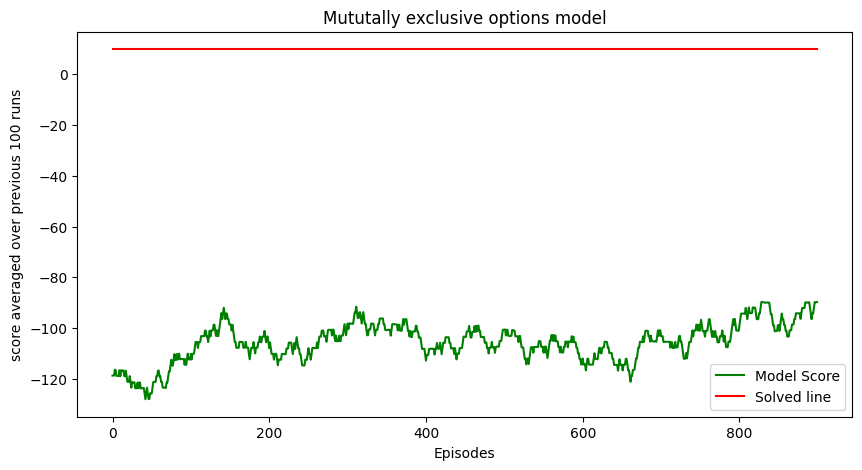

In [ ]:

plt.figure(figsize = (10,5))
avg_rews0 = [np.average(rewards0[i:i+100]) for i in range(len(rewards0)-100)]
plt.plot(avg_rews0,label = 'Model Score',color="green")
plt.plot([9.7 for i in range(len(avg_rews0))],label = 'Solved line',color="red")
plt.xlabel('Episodes')
plt.ylabel('score averaged over previous 100 runs')
plt.title('Mututally exclusive options model')
plt.legend()